# Notebook for QA of Tensor Estimation and Tractography (wilson part)


In [76]:
import os

import nibabel as nib
import numpy as np

#dipy viewing 
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import load_tractogram, save_tractogram
from dipy.io.utils import (create_nifti_header, get_reference_info,
                           is_header_compatible)
from dipy.tracking.streamline import select_random_set_of_streamlines
from dipy.tracking.utils import density_map

from dipy.data.fetcher import (fetch_file_formats,
                               get_file_formats)


# dipy imports
from dipy.tracking.streamline import Streamlines
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.local_tracking import ParticleFilteringTracking
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.tracking.stopping_criterion import ActStoppingCriterion
from dipy.tracking.stopping_criterion import CmcStoppingCriterion

from dipy.reconst.dti import fractional_anisotropy, TensorModel, quantize_evecs
from dipy.reconst.shm import CsaOdfModel
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel, recursive_response
from dipy.reconst.peak_direction_getter import EuDXDirectionGetter

from dipy.data import get_sphere
from dipy.direction import peaks_from_model, ProbabilisticDirectionGetter
from dipy.segment.mask import median_otsu
from dipy.core.gradients import gradient_table

from dipy.data import default_sphere

from dipy.viz import window, actor, has_fury, colormap

import matplotlib.pyplot as plt

# path = '/Users/wilsontang/Desktop/ndmg_outputs/sub_0025841_ses_1/sub-0025841/ses-1/dwi/fiber/streamlines.trk'

## Load Relevent Data to Reload Create Model (wilson part)

In [36]:

bvals = np.loadtxt('/Users/wilsontang/Desktop/Tensor_Estimation_Data/bval.bval')
bvecs = np.loadtxt('/Users/wilsontang/Desktop/Tensor_Estimation_Data/bvec.bvec')
original_im = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/eddy_corrected_data_reor_RAS_nores.nii.gz')

# data_loaded_1 = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/desikan_space-MNI152NLin6_res-2x2x2_reor_RAS_nores_aligned_atlas.nii.gz').get_fdata()
# data_loaded_2 = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/t1w_in_dwi.nii.gz').get_fdata()
# data_loaded_3 = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/t1w_aligned_mni.nii.gz').get_fdata()
# atlas = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/desikan_space-MNI152NLin6_res-2x2x2.nii.gz').get_fdata()
data_original = original_im.get_fdata()

wm_in_dwi_data = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/t1w_wm_in_dwi.nii.gz').get_data().astype("bool")

sphere_mod = get_sphere('repulsion724')

In [37]:
print(data_original.shape)

print(atlas.shape)

print(wm_in_dwi_data.shape)

(128, 124, 60, 93)
(91, 109, 91)
(128, 124, 60)


## CSA ODF Model Visualizations (wilson part)

In [80]:
#build gradient table
gtab = gradient_table(bvals, bvecs)

#running model
csa_model = CsaOdfModel(gtab, sh_order=6)

#
sphere_mod = get_sphere('repulsion724')

#extracting peaks
csa_peaks = peaks_from_model(model=csa_model,
                             data= data_original,
                             sphere=sphere_mod,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             npeaks = 5,
                             normalize_peaks=True,
                             mask = wm_in_dwi_data
                            )



In [39]:
#build odf 
csa_fit = csa_model.fit(data_original)
csa_odf = csa_fit.odf(sphere_mod)

In [19]:
## attempt to slice the peaks and values in the relevent directions to allow for different slice visualizations. 

# ##doesnt work

# y_slice_dirs = csa_peaks.peak_dirs[:,60:61,:,:,:]
# y_slice_vals = csa_peaks.peak_values[:,60:61,:,:]

# print(y_slice_dirs.shape)
# print(y_slice_vals.shape)

(128, 1, 60, 5, 3)
(128, 1, 60, 5)


In [50]:
#clear window
window.clear(ren)

csa_fodf_spheres = actor.odf_slicer(csa_odf, sphere= sphere_mod, scale = 0.3, norm = True, colormap = 'plasma')

ren.add(csa_fodf_spheres)

print('Saving illustration as csa_odfs.png')

window.record(ren,out_path = 'csa_odfs.png', size = (900,900))

Saving illustration as csa_odfs.png


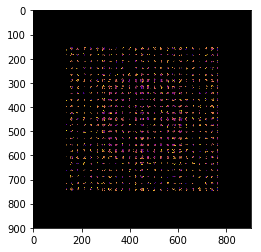

In [58]:
# open method used to open different extension image file 
im = plt.imread('csa_odfs.png')
  
# This method will show image in any image viewer  
plt.imshow(im) 

In [78]:
window.clear(ren)
base_actor = actor.peak_slicer(csa_peaks.peak_dirs,
                csa_peaks.peak_values,
                colors=None)

if has_fury:
    ren = window.Renderer()
    ren.add(base_actor)

    window.record(ren, out_path='csa_direction_field.png', size=(1500, 1500))


#     if interactive:
#         window.show(ren, size=(800, 800))



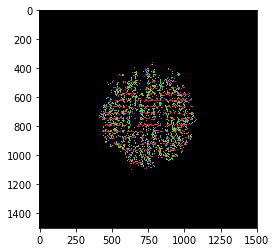

In [79]:
# open method used to open different extension image file 
im = plt.imread('csa_direction_field.png')
  
# This method will show image in any image viewer  
plt.imshow(im) 

In [52]:
csa_fodf_spheres.GetProperty().SetOpacity(0.4)

ren.add(csa_fodf_spheres)

print('Saving illustration as csa_both.png')

window.record(ren,out_path = 'csa_both.png', size = (1200,1200))

Saving illustration as csa_both.png


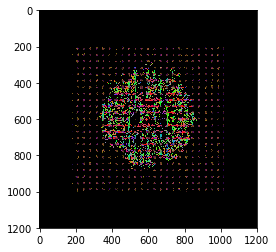

In [61]:
# open method used to open different extension image file 
im = plt.imread('csa_both.png')
  
# This method will show image in any image viewer  
plt.imshow(im)

## CSD Model Visualizations (wilson part)

In [25]:
#build response
response = recursive_response(
                gtab,
                data_original,
                mask =wm_in_dwi_data,
                sh_order=6,
                peak_thr=0.01,
                init_fa=0.08,
                init_trace=0.0021,
                iter=8,
                convergence=0.001,
                parallel=False,
            )

csd_model = ConstrainedSphericalDeconvModel(gtab,response,sh_order=6)

/Users/wilsontang/anaconda3/lib/python3.6/site-packages/dipy/reconst/csdeconv.py:586: UserWarning: maximum number of iterations exceeded - failed to converge
  warnings.warn(msg)


In [27]:
csd_fit = csd_model.fit(data_original)





NameError: name 'sphere_mod' is not defined

In [29]:
csd_odf = csd_fit.odf(sphere_mod)

In [31]:
#show fiber odfs

#clear window
window.clear(ren)

fodf_spheres = actor.odf_slicer(csd_odf, sphere= sphere_mod, scale = 0.9, norm = False, colormap = 'plasma')

ren.add(fodf_spheres)

print('Saving illustration as csd_odfs.png')

window.record(ren,out_path = 'csd_odfs.png', size = (900,900))


Saving illustration as csd_odfs.png


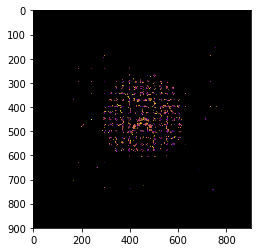

In [62]:
# open method used to open different extension image file 
im = plt.imread('csd_odfs.png')
  
# This method will show image in any image viewer  
plt.imshow(im)

In [32]:
csd_peaks = peaks_from_model(model = csd_model,
                            data = data_original,
                            sphere = sphere_mod,
                            relative_peak_threshold = 0.5,
                            min_separation_angle = 25,
                            npeaks = 5,
                            normalize_peaks=True,
                            mask = wm_in_dwi_data)


Saving illustration as csd_peaks.png


In [34]:
window.clear(ren)

fodf_peaks= actor.peak_slicer(csd_peaks.peak_dirs,csd_peaks.peak_values)
ren.add(fodf_peaks)

print('Saving illustration as csd_peaks.png')

window.record(ren,out_path = 'csd_peaks.png', size = (1200,1200))

Saving illustration as csd_peaks.png


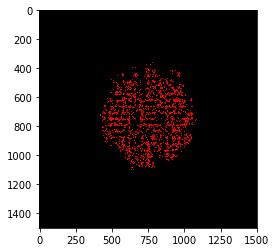

In [63]:
# open method used to open different extension image file 
im = plt.imread('csd_peaks.png')
  
# This method will show image in any image viewer  
plt.imshow(im)

In [35]:
fodf_spheres.GetProperty().SetOpacity(0.4)

ren.add(fodf_spheres)

print('Saving illustration as csd_both.png')


window.record(ren,out_path = 'csd_both.png', size = (1200,1200))

Saving illustration as csd_both.png


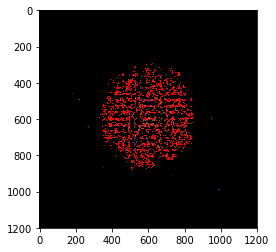

In [64]:
# open method used to open different extension image file 
im = plt.imread('csd_both.png')
  
# This method will show image in any image viewer  
plt.imshow(im)



## Attempt to visualize streamlines (wilson and Zhen Hu co-part)



In [68]:

stream_affine = np.eye(4) 

print('Building Seeds')
#build seeds
seeds = utils.random_seeds_from_mask(
        wm_in_dwi_data,
        affine=stream_affine,
        seeds_count= 1 ,
        seed_count_per_voxel=True,
    )




Building Seeds


In [72]:
print('Selecting Stopping Criteria')
#build stopping criteria
# tiss_classifier = BinaryStoppingCriterion(wm_in_dwi_data)

gm_mask_data = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/t1w_gm_in_dwi.nii.gz').get_data()

vent_csf_in_dwi_data = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/t1w_csf_mask_dwi.nii.gz').get_data()

wm_in_dwi = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/t1w_wm_in_dwi.nii.gz')

voxel_size = np.average(wm_in_dwi.get_header()["pixdim"][1:4])
step_size = 0.2
    
tiss_classifier = CmcStoppingCriterion.from_pve(
    wm_in_dwi_data,
    gm_mask_data,
    vent_csf_in_dwi_data,
    step_size=step_size,
    average_voxel_size=voxel_size,
)


Selecting Stopping Criteria


/Users/wilsontang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  # This is added back by InteractiveShellApp.init_path()


In [88]:

print('Streamline Generator- w/ CMC and Particle')

#create streamline  generator
streamline_generator = ParticleFilteringTracking(
                csa_peaks,
                tiss_classifier,
                seeds,
                stream_affine,
                max_cross= 1 ,
                step_size=0.5,
                maxlen=1000,
                pft_back_tracking_dist=2,
                pft_front_tracking_dist=1,
                particle_count=15,
                return_all=False,
            )

Streamline Generator- w/ CMC and Particle


In [89]:
streamlines_cmc_particle = Streamlines(streamline_generator)

In [90]:
window.clear(ren)

if has_fury:
    r = window.Renderer()
    r.add(actor.line(streamlines_cmc_particle, colormap.line_colors(streamlines_cmc_particle)))
    window.record(r, out_path='tractogram_pft_cmc_particle.png',
                  size=(800, 800))

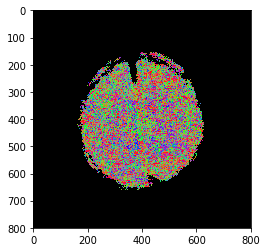

In [91]:
# open method used to open different extension image file 
im = plt.imread('tractogram_pft_cmc_particle.png')
  
# This method will show image in any image viewer  
plt.imshow(im)

In [92]:
print('Streamline Generator w/CMC and Local')

#create streamline  generator
streamline_generator = LocalTracking(
                csa_peaks,
                tiss_classifier,
                seeds,
                stream_affine,
                max_cross= 1 ,
                step_size=0.5,
                maxlen=1000,
#                 pft_back_tracking_dist=2,
#                 pft_front_tracking_dist=1,
#                 particle_count=15,
                return_all=False,
            )

Streamline Generator w/CMC and Local


In [93]:
streamlines_cmc_local = Streamlines(streamline_generator)

In [94]:
window.clear(ren)

if has_fury:
    r = window.Renderer()
    r.add(actor.line(streamlines_cmc_local, colormap.line_colors(streamlines_cmc_local)))
    window.record(r, out_path='tractogram_pft_cmc_local.png',
                  size=(800, 800))

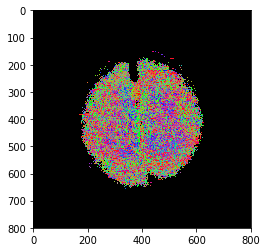

In [95]:
# open method used to open different extension image file 
im = plt.imread('tractogram_pft_cmc_local.png')
  
# This method will show image in any image viewer  
plt.imshow(im)